In [8]:
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)

if not dir1 in sys.path:
    sys.path.append(dir1)

os.chdir('..')

In [16]:
!pip install hydra-core

     ---------------------------------------- 0.0/117.0 kB ? eta -:--:--
     --- ------------------------------------ 10.2/117.0 kB ? eta -:--:--
     ------------------- ----------------- 61.4/117.0 kB 825.8 kB/s eta 0:00:01
     ------------------------------------ 117.0/117.0 kB 979.8 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/154.5 kB ? eta -:--:--
   ---------------------------------------  153.6/154.5 kB 3.1 MB/s eta 0:00:01
   ---------------------------------------- 154.5/154.5 kB 2.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/79.5 kB ? eta -:--:--
   ---------------------------------------- 79.5/79.5 kB 4.6 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144578 sha256=a24ef7466f8dfe98b13a71aff76cf05a8d23ed81f93423df60e7a07c059a879e
  Stored in directory: c:\use

In [16]:
!pip install torch

  Using cached Jinja2-3.1.3-py3-none-any.whl.metadata (3.3 kB)
   ---------------------------------------- 0.0/198.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/198.6 MB 1.9 MB/s eta 0:01:44
   ---------------------------------------- 0.2/198.6 MB 2.1 MB/s eta 0:01:35
   ---------------------------------------- 0.3/198.6 MB 2.4 MB/s eta 0:01:24
   ---------------------------------------- 0.6/198.6 MB 3.2 MB/s eta 0:01:03
   ---------------------------------------- 0.6/198.6 MB 2.9 MB/s eta 0:01:09
   ---------------------------------------- 0.7/198.6 MB 2.5 MB/s eta 0:01:21
   ---------------------------------------- 0.8/198.6 MB 2.4 MB/s eta 0:01:23
   ---------------------------------------- 0.9/198.6 MB 2.4 MB/s eta 0:01:23
   ---------------------------------------- 1.0/198.6 MB 2.4 MB/s eta 0:01:22
   ---------------------------------------- 1.1/198.6 MB 2.4 MB/s eta 0:01:24
   ---------------------------------------- 1.3/198.6 MB 2.5 MB/s eta 0:01:21
   -----

In [88]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import yaml

from src.data.preprocessing import read_data, data_to_np_tensor, preprocess_split
from models.t2v import *
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preprocessing

In [3]:
# data = read_data('data/all_tickers.csv')
# train_data = preprocessing(
#     data, 
#     ['Open', 'High', 'Low', 'Close', 'Volume'],         
#     start_date = '2023-12-15',
#     end_date = '2023-12-21'
# )

# test_data = preprocessing(
#     data, 
#     ['Open', 'High', 'Low', 'Close', 'Volume'],          
#     start_date = '2023-12-21',
#     end_date = '2023-12-22',
#     tickers_save = train_data['Close'].columns
# )

In [4]:
# for feature in ['Open', 'High', 'Low', 'Close', 'Volume']:
#     print(train_data['Close'].shape[1], test_data['Close'].shape[1])

In [5]:
# train_ts = data_to_np_tensor(train_data)
# test_ts = data_to_np_tensor(test_data)

In [6]:
# model = TS2Vec(
#     input_dims=train_ts.shape[2],
#     device=1,
#     output_dims=320
# )

# loss_log = model.fit(
#     train_ts,
#     verbose=False
# )

# test_repr = model.encode(test_ts)
# #test_repr = model.encode(test_data, encoding_window='full_series')

In [7]:
# test_repr = model.encode(test_ts, encoding_window='full_series')
# print(test_repr.shape)
# test_repr

# mean stock price prediction

In [50]:
with open('Stock_Embedding/configs/best_stocks_nans_rate.yaml') as f:
    best_stocks = yaml.load(f, Loader=yaml.FullLoader)
best_stocks = list(best_stocks.keys())
# best_stocks

In [51]:
df = read_data('Stock_Embedding/src/data/all_tickers.csv')
df_best = df.query("Stock in @best_stocks")

In [52]:
df_best

,Date,Time,Open,High,Low,Close,Volume,Datetime,Stock,Day_week
61,2024-01-30,22:58:00,188.130,188.17,188.110,188.14,1500,2024-01-30 22:58:00,AAPL,Tuesday
62,2024-01-30,22:57:00,188.220,188.22,188.080,188.11,5700,2024-01-30 22:57:00,AAPL,Tuesday
63,2024-01-30,22:56:00,188.220,188.27,188.215,188.22,2600,2024-01-30 22:56:00,AAPL,Tuesday
64,2024-01-30,22:55:00,188.150,188.20,188.140,188.20,2100,2024-01-30 22:55:00,AAPL,Tuesday
65,2024-01-30,22:54:00,188.180,188.18,188.140,188.18,2013,2024-01-30 22:54:00,AAPL,Tuesday
...,...,...,...,...,...,...,...,...,...,...
95882,2023-01-30,17:34:00,115.050,115.09,114.960,114.97,800,2023-01-30 17:34:00,XOM,Monday
95883,2023-01-30,17:33:00,115.090,115.27,114.910,115.15,4603,2023-01-30 17:33:00,XOM,Monday
95884,2023-01-30,17:32:00,115.250,115.25,115.000,115.03,850,2023-01-30 17:32:00,XOM,Monday
95885,2023-01-30,17:31:00,115.145,115.16,115.145,115.16,237,2023-01-30 17:31:00,XOM,Monday


In [53]:
dic = {'aa':0,'bb':1,'cc':2}

In [54]:
dic.keys()

dict_keys(['aa', 'bb', 'cc'])

In [55]:
df['Datetime'].min()

Timestamp('2023-01-30 17:30:00')

In [56]:
mask = df['Stock'].apply(lambda x: x in best_stocks) 

In [57]:
df[mask]

,Date,Time,Open,High,Low,Close,Volume,Datetime,Stock,Day_week
61,2024-01-30,22:58:00,188.130,188.17,188.110,188.14,1500,2024-01-30 22:58:00,AAPL,Tuesday
62,2024-01-30,22:57:00,188.220,188.22,188.080,188.11,5700,2024-01-30 22:57:00,AAPL,Tuesday
63,2024-01-30,22:56:00,188.220,188.27,188.215,188.22,2600,2024-01-30 22:56:00,AAPL,Tuesday
64,2024-01-30,22:55:00,188.150,188.20,188.140,188.20,2100,2024-01-30 22:55:00,AAPL,Tuesday
65,2024-01-30,22:54:00,188.180,188.18,188.140,188.18,2013,2024-01-30 22:54:00,AAPL,Tuesday
...,...,...,...,...,...,...,...,...,...,...
95882,2023-01-30,17:34:00,115.050,115.09,114.960,114.97,800,2023-01-30 17:34:00,XOM,Monday
95883,2023-01-30,17:33:00,115.090,115.27,114.910,115.15,4603,2023-01-30 17:33:00,XOM,Monday
95884,2023-01-30,17:32:00,115.250,115.25,115.000,115.03,850,2023-01-30 17:32:00,XOM,Monday
95885,2023-01-30,17:31:00,115.145,115.16,115.145,115.16,237,2023-01-30 17:31:00,XOM,Monday


In [58]:
dd = {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'}

In [59]:
df_best_h = df_best.set_index('Datetime').groupby(
    ['Stock', pd.Grouper(freq='h')],
).agg(dd)

df_best_h

Open    High     Low   Close  Volume
Stock Datetime                                                   
AAPL  2023-01-30 17:00:00  145.15  145.53  144.18  145.13  291457
      2023-01-30 18:00:00  143.97  145.33  143.38  144.96  348830
      2023-01-30 19:00:00  144.07  144.30  143.50  143.95  215404
      2023-01-30 20:00:00  143.38  144.24  143.18  144.17  254970
      2023-01-30 21:00:00  143.31  143.81  143.01  143.38  192383
...                           ...     ...     ...     ...     ...
XOM   2024-01-30 18:00:00  103.69  103.70  102.95  103.22  159389
      2024-01-30 19:00:00  103.79  103.96  103.49  103.67   90110
      2024-01-30 20:00:00  103.68  103.98  103.63  103.76   54009
      2024-01-30 21:00:00  104.15  104.16  103.67  103.68   61363
      2024-01-30 22:00:00  104.38  104.46  104.15  104.15   91004

[42196 rows x 5 columns]

In [60]:
len(df_best_h['Stock'].unique())

KeyError: 'Stock'

In [61]:
df_best_h.groupby('Stock').pct_change().reset_index()

,Stock,Datetime,Open,High,Low,Close,Volume
0,AAPL,2023-01-30 17:00:00,NaN,NaN,NaN,NaN,NaN
1,AAPL,2023-01-30 18:00:00,-0.008130,-0.001374,-0.005549,-0.001171,0.196849
2,AAPL,2023-01-30 19:00:00,0.000695,-0.007087,0.000837,-0.006967,-0.382496
3,AAPL,2023-01-30 20:00:00,-0.004789,-0.000416,-0.002230,0.001528,0.183683
4,AAPL,2023-01-30 21:00:00,-0.000488,-0.002981,-0.001187,-0.005480,-0.245468
...,...,...,...,...,...,...,...
42191,XOM,2024-01-30 18:00:00,0.005430,0.003969,0.008325,0.008106,0.568944
42192,XOM,2024-01-30 19:00:00,0.000964,0.002507,0.005245,0.004360,-0.434654
42193,XOM,2024-01-30 20:00:00,-0.001060,0.000192,0.001353,0.000868,-0.400633
42194,XOM,2024-01-30 21:00:00,0.004533,0.001731,0.000386,-0.000771,0.136162


In [68]:
df = df_best_h.groupby('Stock').pct_change().reset_index()

In [69]:
df

,Stock,Datetime,Open,High,Low,Close,Volume
0,AAPL,2023-01-30 17:00:00,NaN,NaN,NaN,NaN,NaN
1,AAPL,2023-01-30 18:00:00,-0.008130,-0.001374,-0.005549,-0.001171,0.196849
2,AAPL,2023-01-30 19:00:00,0.000695,-0.007087,0.000837,-0.006967,-0.382496
3,AAPL,2023-01-30 20:00:00,-0.004789,-0.000416,-0.002230,0.001528,0.183683
4,AAPL,2023-01-30 21:00:00,-0.000488,-0.002981,-0.001187,-0.005480,-0.245468
...,...,...,...,...,...,...,...
42191,XOM,2024-01-30 18:00:00,0.005430,0.003969,0.008325,0.008106,0.568944
42192,XOM,2024-01-30 19:00:00,0.000964,0.002507,0.005245,0.004360,-0.434654
42193,XOM,2024-01-30 20:00:00,-0.001060,0.000192,0.001353,0.000868,-0.400633
42194,XOM,2024-01-30 21:00:00,0.004533,0.001731,0.000386,-0.000771,0.136162


In [70]:
df['Datetime']

0       2023-01-30 17:00:00
1       2023-01-30 18:00:00
2       2023-01-30 19:00:00
3       2023-01-30 20:00:00
4       2023-01-30 21:00:00
                ...        
42191   2024-01-30 18:00:00
42192   2024-01-30 19:00:00
42193   2024-01-30 20:00:00
42194   2024-01-30 21:00:00
42195   2024-01-30 22:00:00
Name: Datetime, Length: 42196, dtype: datetime64[ns]

In [71]:
df_best_h.loc['AAPL', :]

,Open,High,Low,Close,Volume
Datetime,,,,,
2023-01-30 17:00:00,145.15,145.530,144.18,145.13,291457
2023-01-30 18:00:00,143.97,145.330,143.38,144.96,348830
2023-01-30 19:00:00,144.07,144.300,143.50,143.95,215404
2023-01-30 20:00:00,143.38,144.240,143.18,144.17,254970
2023-01-30 21:00:00,143.31,143.810,143.01,143.38,192383
...,...,...,...,...,...
2024-01-30 18:00:00,188.41,191.170,188.24,190.93,554589
2024-01-30 19:00:00,188.66,188.930,187.87,188.49,310183
2024-01-30 20:00:00,187.98,188.930,187.87,188.76,261810


In [63]:
for stock in df_best_h['Stock'].unique():
    df_best_h[df_best_h['Stock']==stock] = df_best_h[df_best_h['Stock']==stock].pct_change()

KeyError: 'Stock'

In [65]:
df = df_best_h

In [73]:
train_start, train_end = '2023-10-01', '2023-11-01'
test_start, test_end = '2023-11-01', '2023-11-07'


train_data = preprocess_split(
    df, 
    ['Open', 'High', 'Low', 'Close', 'Volume'],         
    start_date = train_start,
    end_date = train_end,
    tickers_save = best_stocks
)

test_data = preprocess_split(
    df, 
    ['Open', 'High', 'Low', 'Close', 'Volume'],          
    start_date = test_start,
    end_date = test_end,
    tickers_save = best_stocks
)

NAN in data  0
NAN in data  0
NAN in data  0
NAN in data  0
NAN in data  0
NAN in data  0
NAN in data  0
NAN in data  0
NAN in data  0
NAN in data  0


In [74]:
train_ts = data_to_np_tensor(train_data)
test_ts = data_to_np_tensor(test_data)

train_ts.shape, test_ts.shape

((28, 132, 5), (28, 24, 5))

In [75]:
train_ts

array([[[ 1.01617707e-02,  1.08784177e-02,  1.21508462e-02,
          8.62671952e-03, -5.79033902e-01],
        [ 5.20321443e-04,  2.99246130e-03,  3.76059475e-04,
         -4.04530744e-04,  8.68174461e-01],
        [ 8.08967988e-04, -4.36054851e-03, -4.62668440e-04,
          4.62507949e-04, -3.66862479e-01],
        ...,
        [ 3.52858151e-03,  3.93955430e-03,  2.98339930e-03,
          2.56440488e-03,  1.08821557e-01],
        [-4.68823254e-04,  0.00000000e+00,  1.08967751e-03,
          2.96945286e-03, -2.23905932e-01],
        [ 1.70028143e-03,  9.37097341e-04,  2.50058837e-03,
          2.93134783e-04,  5.41046204e-01]],

       [[-4.09643409e-03, -6.61322645e-03, -3.89654014e-03,
         -6.62251656e-03, -8.06811021e-01],
        [-6.67565745e-03, -1.47938942e-03, -6.81189721e-03,
         -6.73400673e-05,  1.40605428e+00],
        [-3.86939108e-03, -7.13852785e-03, -3.59907646e-03,
         -7.94666307e-03, -4.17516269e-01],
        ...,
        [ 2.85755108e-04,  1.0706638

In [101]:

from models.t2v import ts2vec
from models.t2v.ts2vec import TS2Vec

model = TS2Vec(
    input_dims=train_ts.shape[2],
    device='cpu',
    output_dims=128
)

loss_log = model.fit(
    train_ts,
    verbose=False
)

In [102]:
train_repr = model.encode(train_ts)
test_repr = model.encode(test_ts)

train_repr.shape, test_repr.shape

((28, 132, 128), (28, 24, 128))

In [103]:
def stock_embeddigns_to_df(data_tensor: np.ndarray, stocks, dates) -> dict:    
    res = pd.DataFrame()
    for i, stock in enumerate(stocks):
        df = pd.DataFrame(data_tensor[i], index=dates)
        df.columns = ['emb_' + str(i) for i in range(len(df.columns))]
        df['Stock'] = stock
        res = pd.concat([res, df])

    return res.reset_index(drop=False, names='Datetime')

X_train = stock_embeddigns_to_df(train_repr, stocks=train_data['Open'].columns, dates=train_data['Open'].index)
X_test = stock_embeddigns_to_df(test_repr, stocks=test_data['Open'].columns, dates=test_data['Open'].index)
X_train.head()

,Datetime,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,...,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127,Stock
0,2023-10-02 17:00:00,-0.184314,0.249737,-0.384614,-0.155163,-0.397252,-0.256223,-0.103385,-0.162283,-0.125338,...,-0.120886,-0.020109,-0.337559,-0.126854,-0.018976,-0.250899,-0.252984,-0.315157,-0.420400,AAPL
1,2023-10-02 18:00:00,0.070170,0.146464,-0.197163,-0.264246,-0.141587,-0.346193,-0.172713,-0.116868,-0.154114,...,-0.192409,0.044032,-0.359902,-0.193976,-0.190348,-0.154893,-0.181766,-0.000841,-0.338270,AAPL
2,2023-10-02 19:00:00,-0.399930,0.214639,-0.153348,-0.311146,-0.255642,-0.050373,-0.060549,-0.328964,-0.120605,...,-0.185462,0.034057,-0.075416,-0.281086,-0.024656,-0.407688,-0.247336,-0.339755,-0.348618,AAPL
3,2023-10-02 20:00:00,-0.173935,0.202667,-0.198649,-0.141378,-0.266638,-0.105595,-0.328143,-0.321269,-0.341376,...,-0.311888,-0.031387,-0.302858,-0.057303,-0.099658,-0.316271,-0.077836,-0.055400,-0.118661,AAPL
4,2023-10-02 21:00:00,-0.102235,0.182182,-0.223493,-0.378933,-0.251534,-0.284374,0.070004,-0.094968,0.018771,...,-0.016124,0.053224,-0.326065,-0.312195,-0.112040,-0.138877,-0.301952,-0.287738,-0.619759,AAPL


In [104]:
y = df_best.set_index('Datetime').groupby(
    ['Stock', pd.Grouper( freq='h')],
).agg({'Close': 'mean'}).reset_index()
y.head()

,Stock,Datetime,Close
0,AAPL,2023-01-30 17:00:00,144.833667
1,AAPL,2023-01-30 18:00:00,144.159833
2,AAPL,2023-01-30 19:00:00,143.951083
3,AAPL,2023-01-30 20:00:00,143.681667
4,AAPL,2023-01-30 21:00:00,143.388167


In [105]:
train_start, train_end = '2023-10-01', '2023-11-01'
test_start, test_end = '2023-11-01', '2023-11-07'

y_train = y[(y['Datetime'].dt.date >= pd.Timestamp(train_start).date()) & 
             (y['Datetime'].dt.date < pd.Timestamp(train_end).date())]

y_test = y[(y['Datetime'].dt.date >= pd.Timestamp(test_start).date()) & 
             (y['Datetime'].dt.date < pd.Timestamp(test_end).date())]

In [106]:
y_name = 'Close'

df_train = pd.merge(X_train, y_train, on=['Stock', 'Datetime'])
df_test = pd.merge(X_test, y_test, on=['Stock', 'Datetime'])

X_train, y_train = df_train.drop(columns=[y_name, 'Datetime', 'Stock']), df_train[y_name]
X_test, y_test = df_test.drop(columns=[y_name, 'Datetime', 'Stock']), df_test[y_name]

In [109]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as MAE
from xgboost import XGBRegressor

model = XGBRegressor()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

MAE(y_test, y_pred)

87.28376826699589

In [111]:
X_train

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127
0,-0.184314,0.249737,-0.384614,-0.155163,-0.397252,-0.256223,-0.103385,-0.162283,-0.125338,-0.005434,...,-0.171424,-0.120886,-0.020109,-0.337559,-0.126854,-0.018976,-0.250899,-0.252984,-0.315157,-0.420400
1,0.070170,0.146464,-0.197163,-0.264246,-0.141587,-0.346193,-0.172713,-0.116868,-0.154114,-0.441418,...,-0.326958,-0.192409,0.044032,-0.359902,-0.193976,-0.190348,-0.154893,-0.181766,-0.000841,-0.338270
2,-0.399930,0.214639,-0.153348,-0.311146,-0.255642,-0.050373,-0.060549,-0.328964,-0.120605,-0.297884,...,0.032938,-0.185462,0.034057,-0.075416,-0.281086,-0.024656,-0.407688,-0.247336,-0.339755,-0.348618
3,-0.173935,0.202667,-0.198649,-0.141378,-0.266638,-0.105595,-0.328143,-0.321269,-0.341376,-0.252420,...,-0.397469,-0.311888,-0.031387,-0.302858,-0.057303,-0.099658,-0.316271,-0.077836,-0.055400,-0.118661
4,-0.102235,0.182182,-0.223493,-0.378933,-0.251534,-0.284374,0.070004,-0.094968,0.018771,-0.319716,...,-0.127558,-0.016124,0.053224,-0.326065,-0.312195,-0.112040,-0.138877,-0.301952,-0.287738,-0.619759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3691,0.034563,0.159970,-0.251561,-0.011274,-0.075994,-0.559839,-0.292820,0.011940,-0.191802,-0.261540,...,-0.490199,-0.030455,-0.011820,-0.453533,-0.157988,-0.182427,-0.026414,-0.187998,-0.030729,-0.303027
3692,-0.481666,0.203970,0.042285,-0.373221,0.005029,-0.069395,-0.186261,-0.206751,-0.062964,-0.515053,...,0.133553,-0.108520,0.112321,0.022319,-0.393528,-0.014094,-0.402508,-0.247272,-0.224389,-0.170293
3693,-0.487015,0.202428,-0.255658,0.252385,-0.263068,-0.112801,-0.499781,-0.400656,-0.456433,-0.013633,...,-0.280630,-0.293328,0.073794,-0.175894,-0.007224,0.036010,-0.500816,0.002365,-0.142507,0.205176
3694,-0.175422,0.140078,-0.215979,-0.335476,-0.140148,-0.309332,-0.073543,0.048950,-0.024196,-0.318570,...,-0.202797,0.108674,0.040410,-0.421283,-0.294285,-0.060924,0.035083,-0.269371,-0.198379,-0.452878


In [112]:
y_train

0       173.344000
1       173.639167
2       173.219500
3       173.224333
4       173.018417
           ...    
3691    105.780667
3692    105.537583
3693    105.716186
3694    105.618500
3695    105.799746
Name: Close, Length: 3696, dtype: float64

In [114]:
!pip install seaborn

   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ---- ----------------------------------- 30.7/294.9 kB 1.3 MB/s eta 0:00:01
   --------- ----------------------------- 71.7/294.9 kB 975.2 kB/s eta 0:00:01
   -------------- ----------------------- 112.6/294.9 kB 930.9 kB/s eta 0:00:01
   -------------- ----------------------- 112.6/294.9 kB 930.9 kB/s eta 0:00:01
   ------------------------------- -------- 235.5/294.9 kB 1.1 MB/s eta 0:00:01
   -------------------------------------- - 286.7/294.9 kB 1.0 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 1.0 MB/s eta 0:00:00


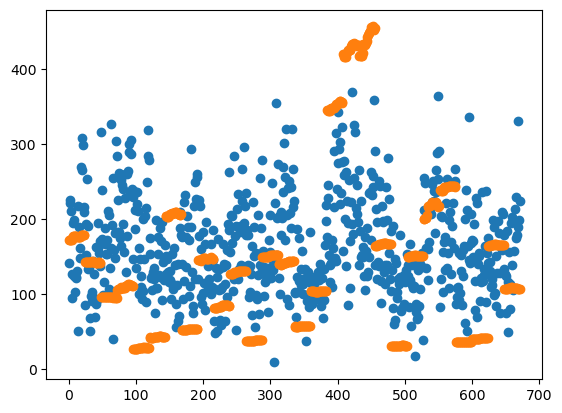

In [113]:
plt.scatter(y = y_pred, x = np.arange(len(y_pred)))
plt.scatter(y = y_test, x = np.arange(len(y_test)))

In [155]:
train = df_train.drop(columns=['Datetime'])

In [126]:
train

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127,Stock,Close
0,-0.184314,0.249737,-0.384614,-0.155163,-0.397252,-0.256223,-0.103385,-0.162283,-0.125338,-0.005434,...,-0.020109,-0.337559,-0.126854,-0.018976,-0.250899,-0.252984,-0.315157,-0.420400,AAPL,173.344000
1,0.070170,0.146464,-0.197163,-0.264246,-0.141587,-0.346193,-0.172713,-0.116868,-0.154114,-0.441418,...,0.044032,-0.359902,-0.193976,-0.190348,-0.154893,-0.181766,-0.000841,-0.338270,AAPL,173.639167
2,-0.399930,0.214639,-0.153348,-0.311146,-0.255642,-0.050373,-0.060549,-0.328964,-0.120605,-0.297884,...,0.034057,-0.075416,-0.281086,-0.024656,-0.407688,-0.247336,-0.339755,-0.348618,AAPL,173.219500
3,-0.173935,0.202667,-0.198649,-0.141378,-0.266638,-0.105595,-0.328143,-0.321269,-0.341376,-0.252420,...,-0.031387,-0.302858,-0.057303,-0.099658,-0.316271,-0.077836,-0.055400,-0.118661,AAPL,173.224333
4,-0.102235,0.182182,-0.223493,-0.378933,-0.251534,-0.284374,0.070004,-0.094968,0.018771,-0.319716,...,0.053224,-0.326065,-0.312195,-0.112040,-0.138877,-0.301952,-0.287738,-0.619759,AAPL,173.018417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3691,0.034563,0.159970,-0.251561,-0.011274,-0.075994,-0.559839,-0.292820,0.011940,-0.191802,-0.261540,...,-0.011820,-0.453533,-0.157988,-0.182427,-0.026414,-0.187998,-0.030729,-0.303027,XOM,105.780667
3692,-0.481666,0.203970,0.042285,-0.373221,0.005029,-0.069395,-0.186261,-0.206751,-0.062964,-0.515053,...,0.112321,0.022319,-0.393528,-0.014094,-0.402508,-0.247272,-0.224389,-0.170293,XOM,105.537583
3693,-0.487015,0.202428,-0.255658,0.252385,-0.263068,-0.112801,-0.499781,-0.400656,-0.456433,-0.013633,...,0.073794,-0.175894,-0.007224,0.036010,-0.500816,0.002365,-0.142507,0.205176,XOM,105.716186
3694,-0.175422,0.140078,-0.215979,-0.335476,-0.140148,-0.309332,-0.073543,0.048950,-0.024196,-0.318570,...,0.040410,-0.421283,-0.294285,-0.060924,0.035083,-0.269371,-0.198379,-0.452878,XOM,105.618500


In [121]:
train['Stock'].value_counts()

Stock
AAPL     132
ABBV     132
WMT      132
WFC      132
VZ       132
V        132
TSLA     132
PG       132
PFE      132
PEP      132
NVDA     132
NFLX     132
MSFT     132
MRK      132
KO       132
JPM      132
JNJ      132
INTC     132
GOOG     132
DIS      132
CVX      132
CSCO     132
CRM      132
CMCSA    132
BAC      132
AMD      132
ABT      132
XOM      132
Name: count, dtype: int64

In [122]:
!pip install category_encoders

   ---------------------------------------- 0.0/81.9 kB ? eta -:--:--
   --------------- ------------------------ 30.7/81.9 kB 1.3 MB/s eta 0:00:01
   ----------------------------------- ---- 71.7/81.9 kB 975.2 kB/s eta 0:00:01
   ---------------------------------------- 81.9/81.9 kB 572.9 kB/s eta 0:00:00
   ---------------------------------------- 0.0/233.9 kB ? eta -:--:--
   ------------ --------------------------- 71.7/233.9 kB 3.8 MB/s eta 0:00:01
   ------------------- -------------------- 112.6/233.9 kB 2.2 MB/s eta 0:00:01
   -------------------------------------- - 225.3/233.9 kB 2.0 MB/s eta 0:00:01
   ---------------------------------------- 233.9/233.9 kB 1.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   ---------------------------------------- 0.1/9.9 MB ? eta -:--:--
   ---------------------------------------- 0.1/9.9 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.9 MB 2.2 MB/s eta 0:00:05
   - --------------

In [156]:
import category_encoders as ce



encoder = ce.TargetEncoder(cols=['Stock'])

df_encoded = encoder.fit_transform(train['Stock'], train['Close'])
train['Stock_int'] = df_encoded['Stock']

In [157]:
train

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127,Stock,Close,Stock_int
0,-0.184314,0.249737,-0.384614,-0.155163,-0.397252,-0.256223,-0.103385,-0.162283,-0.125338,-0.005434,...,-0.337559,-0.126854,-0.018976,-0.250899,-0.252984,-0.315157,-0.420400,AAPL,173.344000,174.494526
1,0.070170,0.146464,-0.197163,-0.264246,-0.141587,-0.346193,-0.172713,-0.116868,-0.154114,-0.441418,...,-0.359902,-0.193976,-0.190348,-0.154893,-0.181766,-0.000841,-0.338270,AAPL,173.639167,174.494526
2,-0.399930,0.214639,-0.153348,-0.311146,-0.255642,-0.050373,-0.060549,-0.328964,-0.120605,-0.297884,...,-0.075416,-0.281086,-0.024656,-0.407688,-0.247336,-0.339755,-0.348618,AAPL,173.219500,174.494526
3,-0.173935,0.202667,-0.198649,-0.141378,-0.266638,-0.105595,-0.328143,-0.321269,-0.341376,-0.252420,...,-0.302858,-0.057303,-0.099658,-0.316271,-0.077836,-0.055400,-0.118661,AAPL,173.224333,174.494526
4,-0.102235,0.182182,-0.223493,-0.378933,-0.251534,-0.284374,0.070004,-0.094968,0.018771,-0.319716,...,-0.326065,-0.312195,-0.112040,-0.138877,-0.301952,-0.287738,-0.619759,AAPL,173.018417,174.494526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3691,0.034563,0.159970,-0.251561,-0.011274,-0.075994,-0.559839,-0.292820,0.011940,-0.191802,-0.261540,...,-0.453533,-0.157988,-0.182427,-0.026414,-0.187998,-0.030729,-0.303027,XOM,105.780667,109.645881
3692,-0.481666,0.203970,0.042285,-0.373221,0.005029,-0.069395,-0.186261,-0.206751,-0.062964,-0.515053,...,0.022319,-0.393528,-0.014094,-0.402508,-0.247272,-0.224389,-0.170293,XOM,105.537583,109.645881
3693,-0.487015,0.202428,-0.255658,0.252385,-0.263068,-0.112801,-0.499781,-0.400656,-0.456433,-0.013633,...,-0.175894,-0.007224,0.036010,-0.500816,0.002365,-0.142507,0.205176,XOM,105.716186,109.645881
3694,-0.175422,0.140078,-0.215979,-0.335476,-0.140148,-0.309332,-0.073543,0.048950,-0.024196,-0.318570,...,-0.421283,-0.294285,-0.060924,0.035083,-0.269371,-0.198379,-0.452878,XOM,105.618500,109.645881


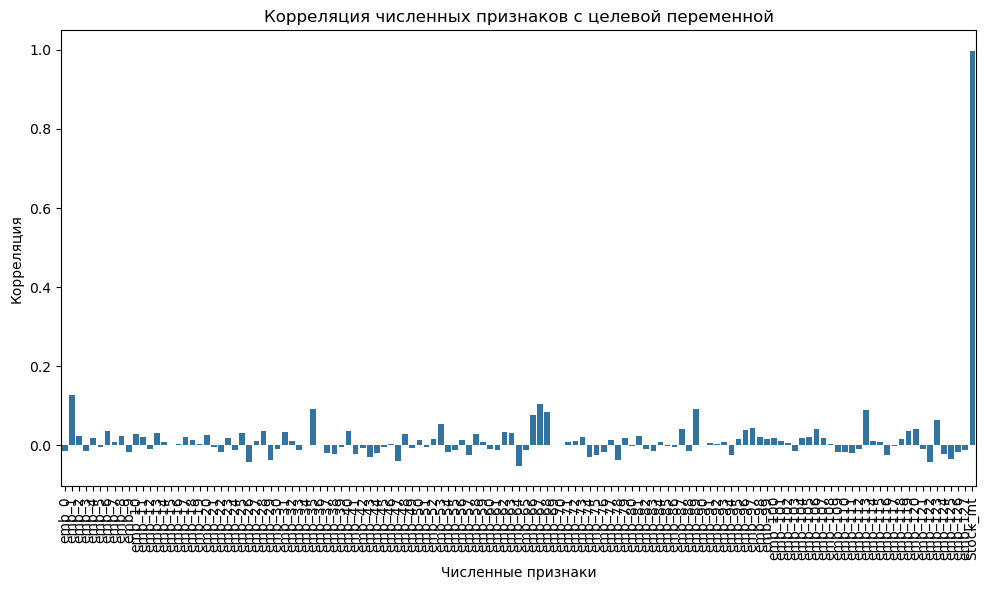

In [159]:
import seaborn as sns
correlation_matrix = train.drop(columns=['Stock']).corr()


target_correlation = correlation_matrix['Close']


target_correlation = target_correlation.drop('Close')

# Создание графика корреляции
plt.figure(figsize=(10, 6))
sns.barplot(x=target_correlation.index, y=target_correlation.values)
plt.title('Корреляция численных признаков с целевой переменной')
plt.xlabel('Численные признаки')
plt.ylabel('Корреляция')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [160]:
correlation_with_target = correlation_matrix['Close'].abs()

top_30_correlated_features = correlation_with_target.sort_values(ascending=False).head(30)

print(top_30_correlated_features)


Close        1.000000
Stock_int    0.997255
emb_1        0.126312
emb_67       0.104116
emb_89       0.092153
emb_35       0.091113
emb_113      0.087727
emb_68       0.084966
emb_66       0.075465
emb_123      0.062956
emb_53       0.052525
emb_64       0.051618
emb_97       0.043432
emb_26       0.043229
emb_122      0.042348
emb_87       0.041888
emb_120      0.041348
emb_47       0.041054
emb_106      0.040676
emb_96       0.039465
emb_78       0.037863
emb_29       0.037444
emb_119      0.036641
emb_28       0.036435
emb_40       0.036112
emb_6        0.035459
emb_125      0.034917
emb_31       0.034052
emb_62       0.032036
emb_63       0.031362
Name: Close, dtype: float64


d:\aleks\anaconda3\envs\T2V\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\aleks\anaconda3\envs\T2V\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=15.
  warnings.warn(


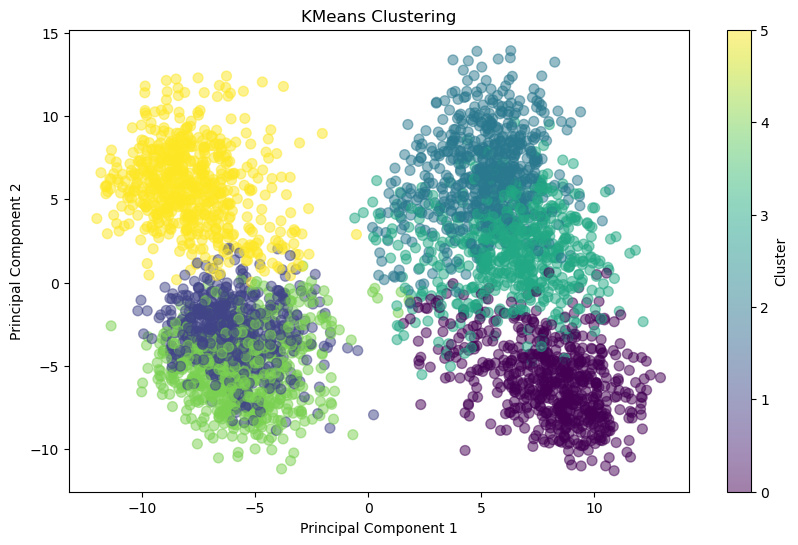

In [161]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Предположим, у вас есть DataFrame с вашими данными в переменной data

# Применяем стандартизацию данных (нормализация)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(train.drop(columns=['Stock_int', 'Close', 'Stock']))

# Применяем метод главных компонент (PCA) для снижения размерности данных до 2 компонент
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

# Применяем алгоритм KMeans
kmeans = KMeans(n_clusters=6, random_state=42)  # Указываем количество кластеров
kmeans.fit(scaled_data)

# Получаем метки кластеров для каждого объекта
cluster_labels = kmeans.labels_

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=cluster_labels, cmap='viridis', s=50, alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering')
plt.colorbar(label='Cluster')
plt.show()


In [162]:
train['cluster'] = cluster_labels

In [163]:
train['cluster'].value_counts()

cluster
4    635
3    617
5    615
2    613
0    611
1    605
Name: count, dtype: int64

In [211]:
def top_mode(data):
    mode_counts = data.value_counts()
    top_5_mode = mode_counts.head(7)
    return top_5_mode



In [173]:
pd.set_option('display.max_rows', 250)

In [213]:
for i in range(6):
    print(f'{i} Кластер')
    print(f'Число повторений в кластере: {top_mode(train[train["cluster"] == i]["Stock"])}')
    


0 Кластер
Число повторений в кластере: Stock
AAPL    23
V       23
CRM     23
PFE     23
JPM     22
WMT     22
WFC     22
Name: count, dtype: int64
1 Кластер
Число повторений в кластере: Stock
PEP     23
INTC    23
AAPL    22
ABBV    22
WMT     22
WFC     22
VZ      22
Name: count, dtype: int64
2 Кластер
Число повторений в кластере: Stock
NFLX    23
JNJ     23
AAPL    22
ABBV    22
WMT     22
WFC     22
VZ      22
Name: count, dtype: int64
3 Кластер
Число повторений в кластере: Stock
TSLA    24
NVDA    24
AMD     23
KO      22
ABBV    22
WMT     22
WFC     22
Name: count, dtype: int64
4 Кластер
Число повторений в кластере: Stock
TSLA     29
NVDA     28
AMD      26
XOM      24
CMCSA    23
GOOG     23
MRK      22
Name: count, dtype: int64
5 Кластер
Число повторений в кластере: Stock
CRM     23
NFLX    23
AAPL    22
ABBV    22
WMT     22
WFC     22
VZ      22
Name: count, dtype: int64


# baseline

In [196]:
X_baseline = df_best.set_index('Datetime').groupby(
    ['Stock', pd.Grouper( freq='h')],
).agg({'Close': 'mean'}).reset_index()
X_baseline.head()

,Stock,Datetime,Close
0,AAPL,2023-01-30 17:00:00,144.833667
1,AAPL,2023-01-30 18:00:00,144.159833
2,AAPL,2023-01-30 19:00:00,143.951083
3,AAPL,2023-01-30 20:00:00,143.681667
4,AAPL,2023-01-30 21:00:00,143.388167


In [197]:
n_shifts = 18
for i in range(1, n_shifts + 1):
    X_baseline[f'shift_{i}'] = X_baseline.groupby(by=['Stock']).shift(i)['Close']

X_baseline = X_baseline.dropna()
X_baseline = X_baseline.drop(columns='Close')
X_baseline.head()

,Stock,Datetime,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12,shift_13,shift_14,shift_15,shift_16,shift_17,shift_18
18,AAPL,2023-02-02 17:00:00,143.121271,142.186500,142.061917,142.751167,142.929167,143.026833,143.825508,143.472250,143.434917,143.335833,143.010000,142.988000,143.219153,143.388167,143.681667,143.951083,144.159833,144.833667
19,AAPL,2023-02-02 18:00:00,149.049167,143.121271,142.186500,142.061917,142.751167,142.929167,143.026833,143.825508,143.472250,143.434917,143.335833,143.010000,142.988000,143.219153,143.388167,143.681667,143.951083,144.159833
20,AAPL,2023-02-02 19:00:00,149.299833,149.049167,143.121271,142.186500,142.061917,142.751167,142.929167,143.026833,143.825508,143.472250,143.434917,143.335833,143.010000,142.988000,143.219153,143.388167,143.681667,143.951083
21,AAPL,2023-02-02 20:00:00,149.979417,149.299833,149.049167,143.121271,142.186500,142.061917,142.751167,142.929167,143.026833,143.825508,143.472250,143.434917,143.335833,143.010000,142.988000,143.219153,143.388167,143.681667
22,AAPL,2023-02-02 21:00:00,149.869333,149.979417,149.299833,149.049167,143.121271,142.186500,142.061917,142.751167,142.929167,143.026833,143.825508,143.472250,143.434917,143.335833,143.010000,142.988000,143.219153,143.388167


In [198]:
y = df_best.set_index('Datetime').groupby(
    ['Stock', pd.Grouper( freq='h')],
).agg({'Close': 'mean'}).reset_index()
y.head()

,Stock,Datetime,Close
0,AAPL,2023-01-30 17:00:00,144.833667
1,AAPL,2023-01-30 18:00:00,144.159833
2,AAPL,2023-01-30 19:00:00,143.951083
3,AAPL,2023-01-30 20:00:00,143.681667
4,AAPL,2023-01-30 21:00:00,143.388167


In [199]:
train_start, train_end = '2023-10-01', '2023-11-01'
test_start, test_end = '2023-11-01', '2023-11-07'

y_train = y[(y['Datetime'].dt.date >= pd.Timestamp(train_start).date()) & 
             (y['Datetime'].dt.date < pd.Timestamp(train_end).date())]

y_test = y[(y['Datetime'].dt.date >= pd.Timestamp(test_start).date()) & 
             (y['Datetime'].dt.date < pd.Timestamp(test_end).date())]

X_train = X_baseline[(X_baseline['Datetime'].dt.date >= pd.Timestamp(train_start).date()) & 
             (X_baseline['Datetime'].dt.date < pd.Timestamp(train_end).date())]

X_test = X_baseline[(X_baseline['Datetime'].dt.date >= pd.Timestamp(test_start).date()) & 
             (X_baseline['Datetime'].dt.date < pd.Timestamp(test_end).date())]

In [200]:
y_name = 'Close'

df_train = pd.merge(X_train, y_train, on=['Stock', 'Datetime'])
df_test = pd.merge(X_test, y_test, on=['Stock', 'Datetime'])

X_train, y_train = df_train.drop(columns=[y_name, 'Datetime', 'Stock']), df_train[y_name]
X_test, y_test = df_test.drop(columns=[y_name, 'Datetime', 'Stock']), df_test[y_name]

In [180]:
X_train

,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12,shift_13,shift_14,shift_15,shift_16,shift_17,shift_18
0,171.311695,170.744583,171.005583,171.718583,172.111083,172.523333,170.999915,170.717667,170.963167,171.560167,170.608667,169.657333,170.279068,169.947333,169.615583,169.937500,170.682500,170.882167
1,173.344000,171.311695,170.744583,171.005583,171.718583,172.111083,172.523333,170.999915,170.717667,170.963167,171.560167,170.608667,169.657333,170.279068,169.947333,169.615583,169.937500,170.682500
2,173.639167,173.344000,171.311695,170.744583,171.005583,171.718583,172.111083,172.523333,170.999915,170.717667,170.963167,171.560167,170.608667,169.657333,170.279068,169.947333,169.615583,169.937500
3,173.219500,173.639167,173.344000,171.311695,170.744583,171.005583,171.718583,172.111083,172.523333,170.999915,170.717667,170.963167,171.560167,170.608667,169.657333,170.279068,169.947333,169.615583
4,173.224333,173.219500,173.639167,173.344000,171.311695,170.744583,171.005583,171.718583,172.111083,172.523333,170.999915,170.717667,170.963167,171.560167,170.608667,169.657333,170.279068,169.947333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3691,105.645167,105.760847,105.542583,105.651525,105.511695,105.422000,105.671333,105.205508,105.709667,105.430932,105.270000,105.476417,105.653333,107.394224,107.236983,106.939000,107.064375,107.374333
3692,105.780667,105.645167,105.760847,105.542583,105.651525,105.511695,105.422000,105.671333,105.205508,105.709667,105.430932,105.270000,105.476417,105.653333,107.394224,107.236983,106.939000,107.064375
3693,105.537583,105.780667,105.645167,105.760847,105.542583,105.651525,105.511695,105.422000,105.671333,105.205508,105.709667,105.430932,105.270000,105.476417,105.653333,107.394224,107.236983,106.939000
3694,105.716186,105.537583,105.780667,105.645167,105.760847,105.542583,105.651525,105.511695,105.422000,105.671333,105.205508,105.709667,105.430932,105.270000,105.476417,105.653333,107.394224,107.236983


In [181]:
y_train

0       173.344000
1       173.639167
2       173.219500
3       173.224333
4       173.018417
           ...    
3691    105.780667
3692    105.537583
3693    105.716186
3694    105.618500
3695    105.799746
Name: Close, Length: 3696, dtype: float64

In [183]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as MAE

model = RandomForestRegressor()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

MAE(y_test, y_pred)

0.9715501290587809

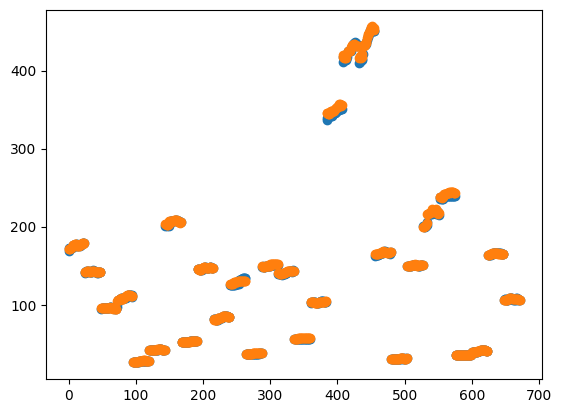

In [45]:
plt.scatter(y = y_pred, x = np.arange(len(y_pred)))
plt.scatter(y = y_test, x = np.arange(len(y_test)))

## Сдвиги как фичи

In [185]:
shifts = X_train

In [201]:
shifts_test = X_test

In [203]:
def stock_embeddigns_to_df(data_tensor: np.ndarray, stocks, dates) -> dict:    
    res = pd.DataFrame()
    for i, stock in enumerate(stocks):
        df = pd.DataFrame(data_tensor[i], index=dates)
        df.columns = ['emb_' + str(i) for i in range(len(df.columns))]
        df['Stock'] = stock
        res = pd.concat([res, df])

    return res.reset_index(drop=False, names='Datetime')

X_train = stock_embeddigns_to_df(train_repr, stocks=train_data['Open'].columns, dates=train_data['Open'].index)
X_test = stock_embeddigns_to_df(test_repr, stocks=test_data['Open'].columns, dates=test_data['Open'].index)
X_train.head()

,Datetime,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,...,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127,Stock
0,2023-10-02 17:00:00,-0.184314,0.249737,-0.384614,-0.155163,-0.397252,-0.256223,-0.103385,-0.162283,-0.125338,...,-0.120886,-0.020109,-0.337559,-0.126854,-0.018976,-0.250899,-0.252984,-0.315157,-0.420400,AAPL
1,2023-10-02 18:00:00,0.070170,0.146464,-0.197163,-0.264246,-0.141587,-0.346193,-0.172713,-0.116868,-0.154114,...,-0.192409,0.044032,-0.359902,-0.193976,-0.190348,-0.154893,-0.181766,-0.000841,-0.338270,AAPL
2,2023-10-02 19:00:00,-0.399930,0.214639,-0.153348,-0.311146,-0.255642,-0.050373,-0.060549,-0.328964,-0.120605,...,-0.185462,0.034057,-0.075416,-0.281086,-0.024656,-0.407688,-0.247336,-0.339755,-0.348618,AAPL
3,2023-10-02 20:00:00,-0.173935,0.202667,-0.198649,-0.141378,-0.266638,-0.105595,-0.328143,-0.321269,-0.341376,...,-0.311888,-0.031387,-0.302858,-0.057303,-0.099658,-0.316271,-0.077836,-0.055400,-0.118661,AAPL
4,2023-10-02 21:00:00,-0.102235,0.182182,-0.223493,-0.378933,-0.251534,-0.284374,0.070004,-0.094968,0.018771,...,-0.016124,0.053224,-0.326065,-0.312195,-0.112040,-0.138877,-0.301952,-0.287738,-0.619759,AAPL


In [204]:
y = df_best.set_index('Datetime').groupby(
    ['Stock', pd.Grouper( freq='h')],
).agg({'Close': 'mean'}).reset_index()
y.head()

,Stock,Datetime,Close
0,AAPL,2023-01-30 17:00:00,144.833667
1,AAPL,2023-01-30 18:00:00,144.159833
2,AAPL,2023-01-30 19:00:00,143.951083
3,AAPL,2023-01-30 20:00:00,143.681667
4,AAPL,2023-01-30 21:00:00,143.388167


In [205]:
train_start, train_end = '2023-10-01', '2023-11-01'
test_start, test_end = '2023-11-01', '2023-11-07'

y_train = y[(y['Datetime'].dt.date >= pd.Timestamp(train_start).date()) & 
             (y['Datetime'].dt.date < pd.Timestamp(train_end).date())]

y_test = y[(y['Datetime'].dt.date >= pd.Timestamp(test_start).date()) & 
             (y['Datetime'].dt.date < pd.Timestamp(test_end).date())]

In [206]:
y_name = 'Close'

df_train = pd.merge(X_train, y_train, on=['Stock', 'Datetime'])
df_test = pd.merge(X_test, y_test, on=['Stock', 'Datetime'])

X_train, y_train = df_train.drop(columns=[y_name, 'Datetime', 'Stock']), df_train[y_name]
X_test, y_test = df_test.drop(columns=[y_name, 'Datetime', 'Stock']), df_test[y_name]

In [207]:
X_train = pd.concat([X_train, shifts], axis=1)
X_test = pd.concat([X_test, shifts_test], axis=1)

In [195]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3696 entries, 0 to 3695
Columns: 146 entries, emb_0 to shift_18
dtypes: float32(128), float64(18)
memory usage: 2.3 MB


In [209]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as MAE
from xgboost import XGBRegressor

model = XGBRegressor()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

MAE(y_test, y_pred)

1.9165824852111188